# Import

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.basics import *
from fastai.metrics import accuracy
from fastai.torch_core import *
from fastai.vision import *
fastai.__version__

'1.0.51'

In [3]:
from fastai_audio import *

# Data

In [4]:
# The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))
untar_data(data_url, dest = data_folder)

WindowsPath('D:/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [5]:
data_folder.ls()[:2]

[WindowsPath('D:/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00001.wav'),
 WindowsPath('D:/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00002.wav')]

# Dataloader

In [15]:
from fastai_audio import *

n_fft = 512 # output of fft will have shape [513 x n_frames]
n_hop = 160  # width of Spectogram = max_seconds * sample rate / n_hop
n_mels = 128 # Height of spectogram
sample_rate = 16000
convert_to_mono=True
max_seconds = 5
f_min=0
f_max=None#8000
noise_scl=0.0005
top_db=80.

train_tfms = get_data_augmentation_transforms(sample_rate=sample_rate, max_seconds=max_seconds, 
                                              convert_to_mono=convert_to_mono,
                                              noise_scl=noise_scl)
valid_tfms = get_data_augmentation_transforms(sample_rate=sample_rate, max_seconds=max_seconds, 
                                              convert_to_mono=convert_to_mono)

dl_tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                            n_mels=n_mels, top_db=top_db,
                                            f_min=f_min, f_max=f_max,
                                            sample_rate=sample_rate)

In [16]:
%%time
from fastai_audio import *
batch_size = 64

label_pattern = r'_([mf]\d+)_'

audios = (AudioItemList.from_folder(data_folder, extensions=".wav", using_librosa=True)
          .split_by_rand_pct(0.1)
          .label_from_re(label_pattern)
          .transform(tfms=(train_tfms, valid_tfms))
          .databunch(bs=batch_size, tfms=dl_tfms, num_workers=0)
         ).normalize()

Wall time: 493 ms


In [17]:
audios.c, len(audios.train_ds), len(audios.valid_ds)

(10, 3458, 384)

# Look at data from dataloader

In [18]:
xs, ys = audios.one_batch()
print(xs.shape, ys.shape)
del xs, ys

torch.Size([64, 1, 128, 501]) torch.Size([64])


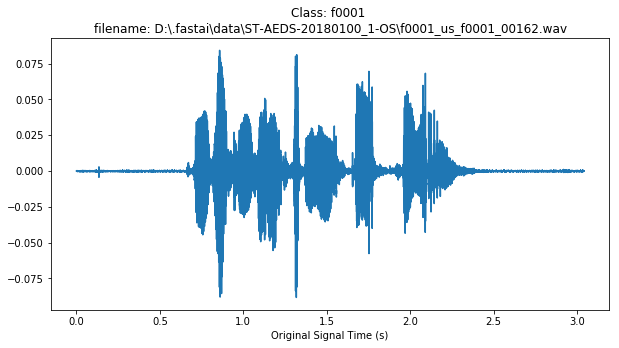

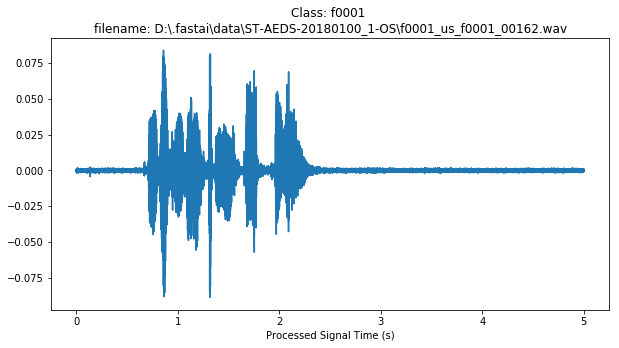

'Original signal'

'Processed signal'

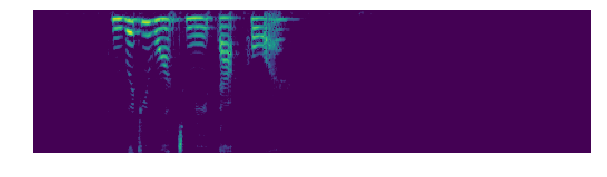

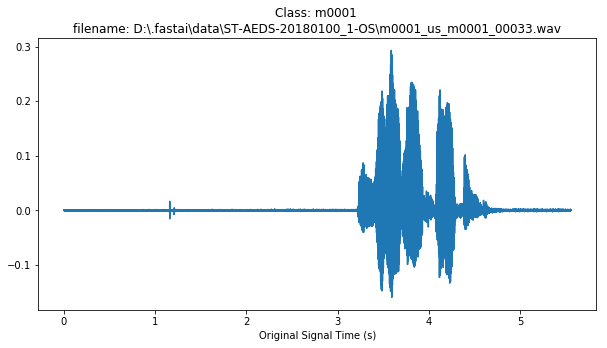

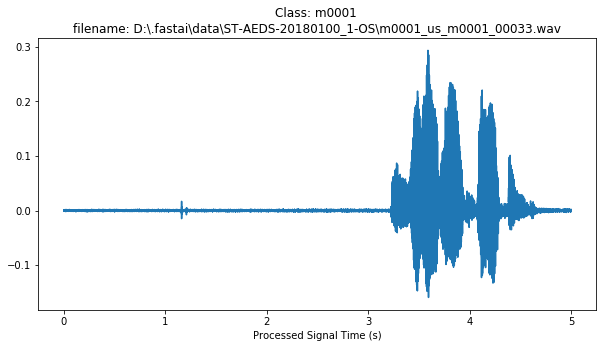

'Original signal'

'Processed signal'

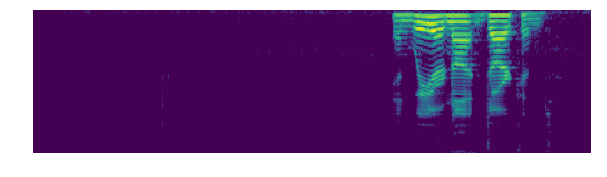

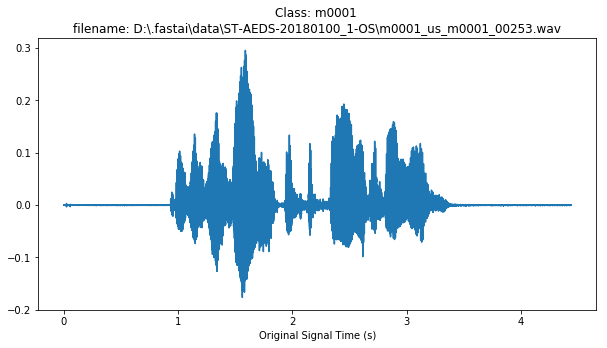

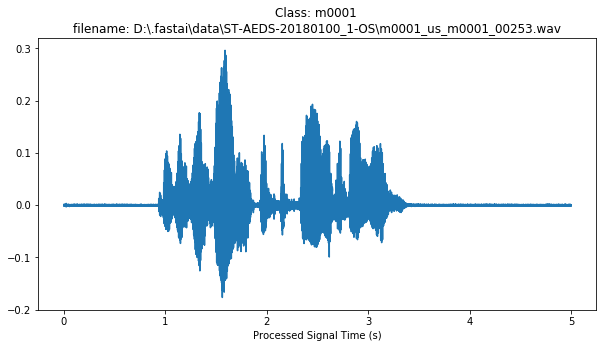

'Original signal'

'Processed signal'

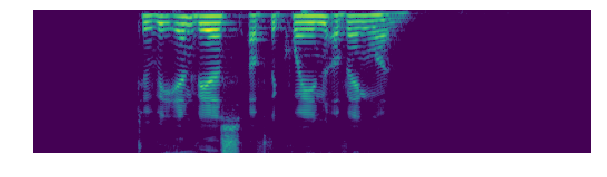

In [19]:
audios.show_batch(3, ds_type=DatasetType.Train, figsize=(10, 5))

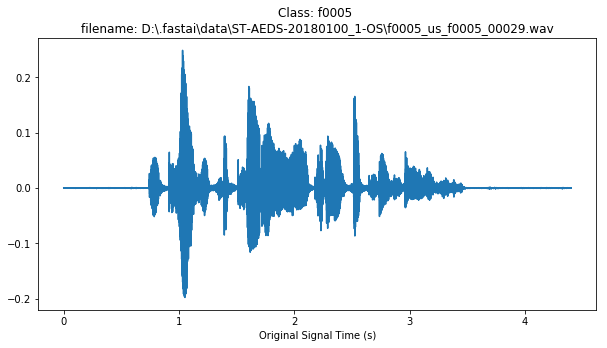

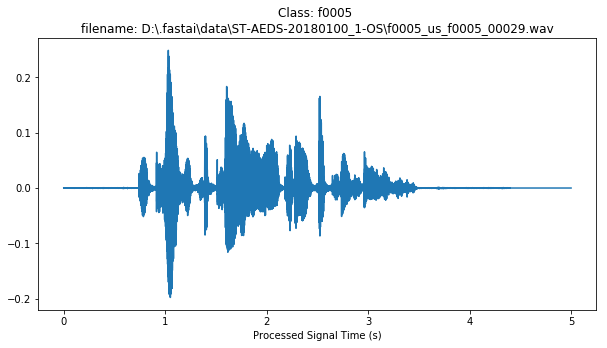

'Original signal'

'Processed signal'

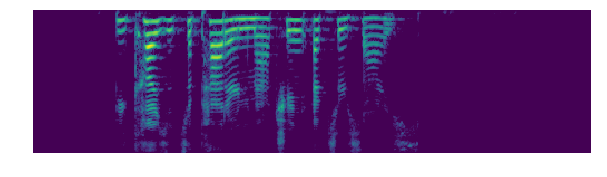

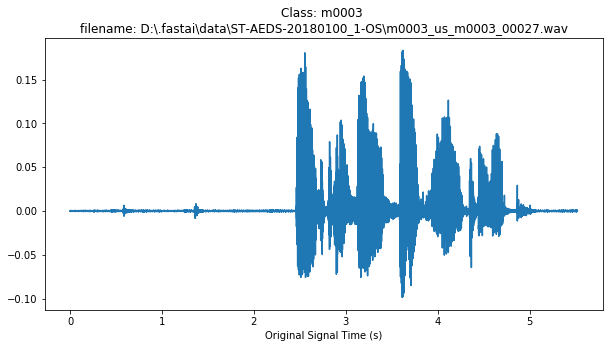

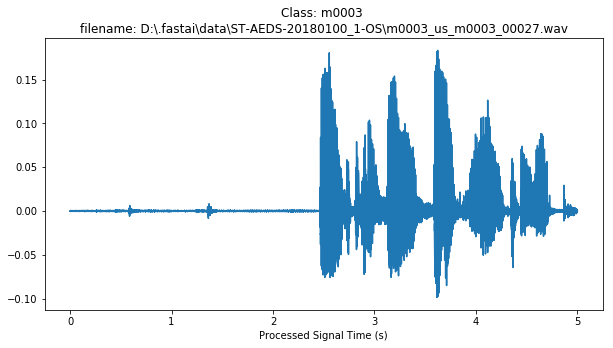

'Original signal'

'Processed signal'

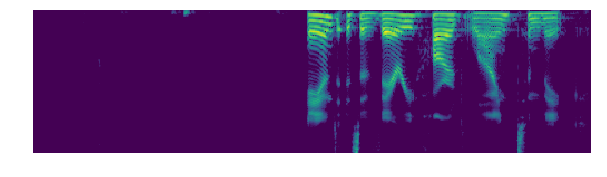

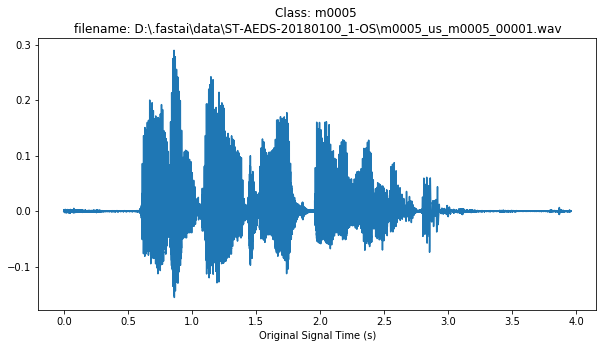

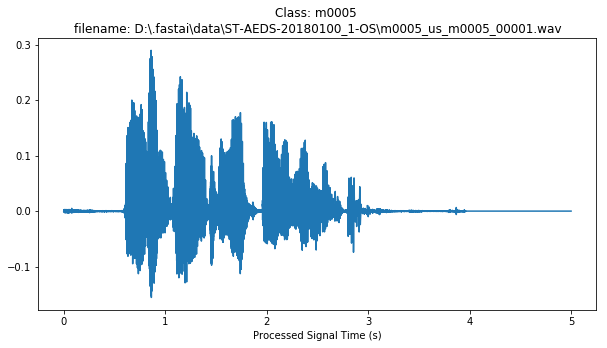

'Original signal'

'Processed signal'

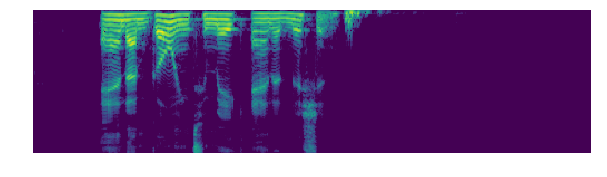

In [20]:
audios.show_batch(3, ds_type=DatasetType.Valid, figsize=(10, 5))

# Model

In [23]:
learn = create_cnn(audios, models.resnet18, metrics=accuracy, is_mono_input=True)

# Training

In [24]:
learn.fit_one_cycle(8, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.753202,0.497768,0.820312,00:18
1,0.283707,0.964574,0.736979,00:18
2,0.128788,0.619968,0.817708,00:17
3,0.081370,1.596760,0.601562,00:17
4,0.062937,0.152183,0.966146,00:18
5,0.038748,0.060024,0.986979,00:18
6,0.019827,0.045483,0.992188,00:18
7,0.009633,0.043840,0.992188,00:18


# Results & Interpretation

No benchmark found to compare results

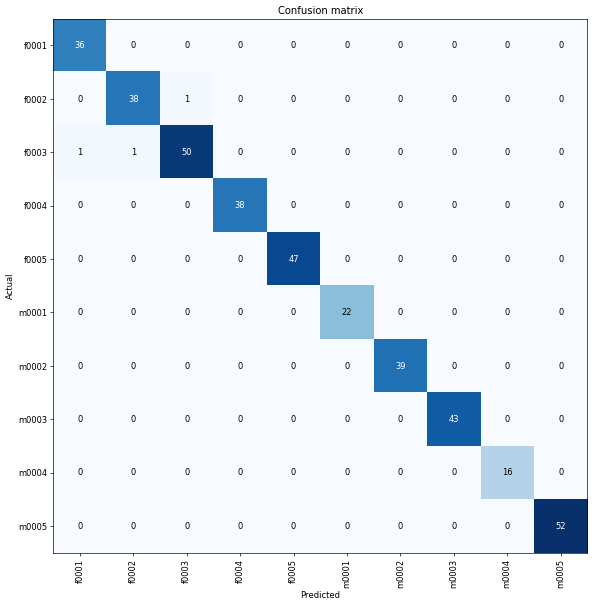

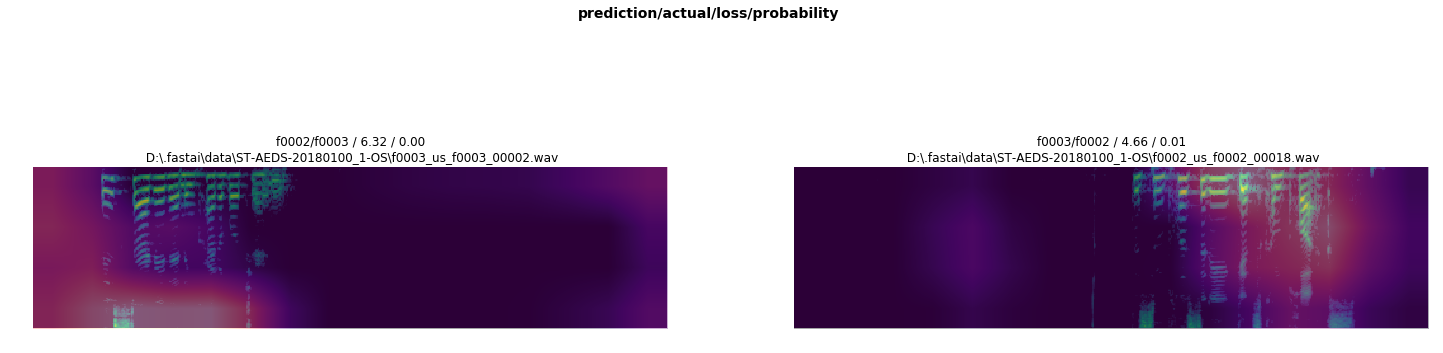

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)
interp.plot_audio_top_losses(2)